In [21]:
import investpy as inv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import math
import yfinance as yf
plt.rcParams['figure.figsize'] = 15,6

In [2]:
def retorno_acm(series):
    retorno_acm = (1+series).cumprod()
    return retorno_acm

def retorno_percentual(acm1,acm2,acm3):
    return (acm1[-1]-1,acm2[-1]-1,acm3[-1]-1)
    
    
def vol_anual(series):
    vol_anual = round(series.std()*math.sqrt(252),2)
    return vol_anual

def sharpe(ri,rf,vol):
    indice=(ri-rf)/vol
    return indice

def import_indices(indice, column_rename):
    indice = pd.read_csv(r'C:\Users\Lucas\Downloads\{}.csv'.format(indice),sep=';')
    indice['data'] = pd.to_datetime(indice['Data'], dayfirst=True, errors='coerce')
    indice.drop(['Data'],axis=1, inplace=True)
    indice.rename(columns={indice.columns[0]: column_rename}, inplace=True)
    indice.set_index('data', inplace=True)
    indice.drop(index=indice.index[-1], inplace=True)
    indice = indice[column_rename].str.replace(',','.')
    indice = indice.astype(float)
    indice = indice.squeeze()
    return indice

In [3]:
ip = inv.funds.get_fund_historical_data(fund='Ip Participações Fundo De Investimento Em Cotas De Fundos De Investimento Em Ações Bdr Nível I',
                                        country='Brazil',
                                        from_date='01/01/2019',
                                        to_date='31/12/2021')['Close']

In [4]:
lis = inv.funds.get_fund_historical_data(fund='Lis Value Fundo De Investimento Em Ações',
                                        country='Brazil',
                                        from_date='01/01/2019',
                                        to_date='31/12/2021')['Close']

In [5]:
alaska = inv.funds.get_fund_historical_data(fund='Alaska Black Institucional Fundo De Investimento De Acoes',
                                            country='Brazil',
                                            from_date='01/01/2019',
                                            to_date='31/12/2021')['Close']

In [6]:
ibov = yf.download(tickers='^BVSP')[['Adj Close']].reset_index()
ibov = ibov[(ibov['Date'] > '01-01-2019') & (ibov['Date'] <= '31-12-2021')].set_index('Date').squeeze()

[*********************100%***********************]  1 of 1 completed


In [7]:
cdi = import_indices('cdi','cdi')
ipca = import_indices('ipca','ipca')

In [8]:
ip_retornos = ip.pct_change()
alaska_retornos = alaska.pct_change()
lis_retornos = lis.pct_change()
ibov_retornos = ibov.pct_change()

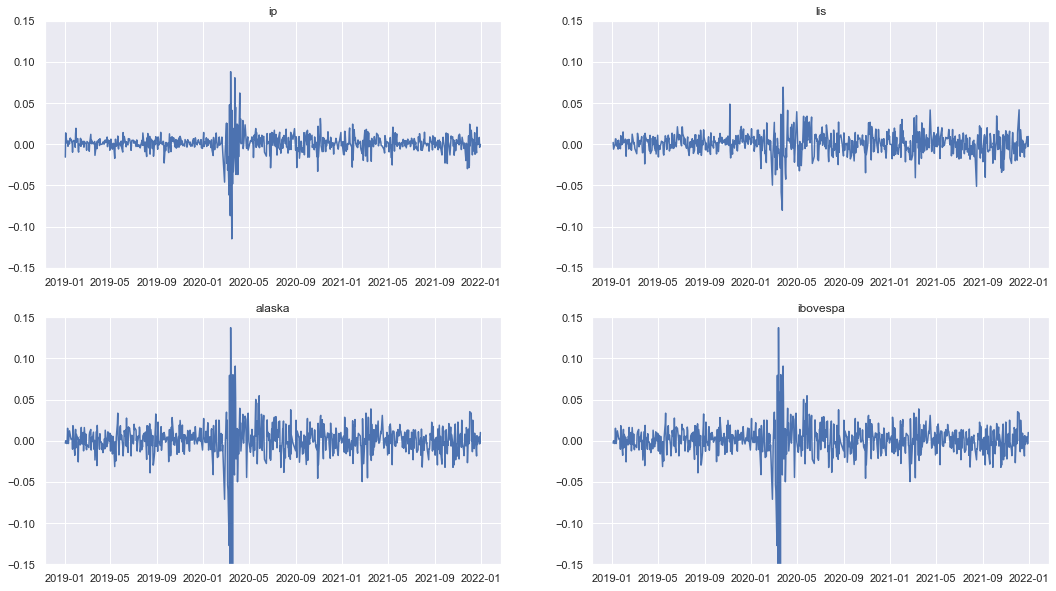

In [9]:
plt.figure(figsize=(18,10))
plt.subplot(2, 2, 1)
plt.plot(ip_retornos)
plt.title('ip')
plt.ylim(-0.15, 0.15) 

plt.subplot(2, 2, 2)
plt.plot(lis_retornos)
plt.title('lis')
plt.ylim(-0.15, 0.15) 

plt.subplot(2, 2, 3)
plt.plot(alaska_retornos)
plt.title('alaska')
plt.ylim(-0.15, 0.15)

plt.subplot(2, 2, 4)
plt.plot(alaska_retornos)
plt.title('ibovespa')
plt.ylim(-0.15, 0.15) 

plt.show()

In [10]:
ip_acm = retorno_acm(ip_retornos)
alaska_acm = retorno_acm(alaska_retornos)
lis_acm = retorno_acm(lis_retornos)
ibov_acm = retorno_acm(ibov_retornos)

ipca_acm = (1+ ipca / 100).cumprod()
cdi_acm = (1+ cdi / 100).cumprod()

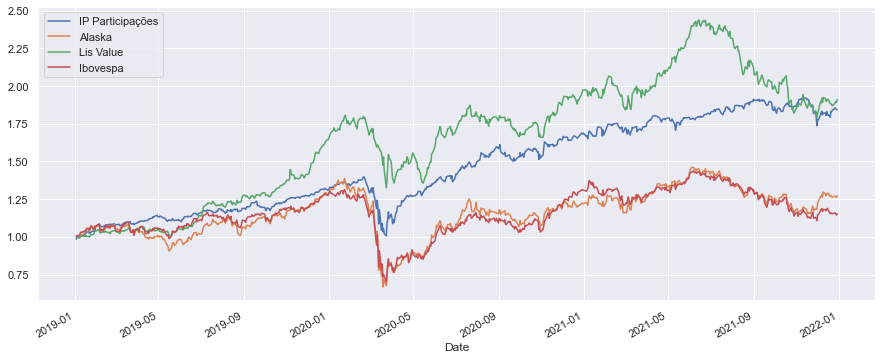

In [11]:
ip_acm.plot(label='IP Participações')
alaska_acm.plot(label='Alaska')
lis_acm.plot(label='Lis Value')
ibov_acm.plot(label='Ibovespa')

plt.legend()
plt.show()

In [12]:
vol_anual_ip = vol_anual(ip_retornos)
vol_anual_alaska = vol_anual(alaska_retornos)
vol_anual_lis = vol_anual(lis_retornos)
vol_anual_ibov = vol_anual(ibov_retornos)

print('Volatilidade Anualizada do Fundo IP Participações: ' +str(vol_anual_ip*100))
print('Volatilidade Anualizada do Fundo Alaska: ' +str(vol_anual_alaska*100))
print('Volatilidade Anualizada do Fundo Lis Value: ' +str(vol_anual_lis*100))
print('Volatilidade Anualizada do Ibovespa: ' +str(vol_anual_ibov*100))

Volatilidade Anualizada do Fundo IP Participações: 20.0
Volatilidade Anualizada do Fundo Alaska: 34.0
Volatilidade Anualizada do Fundo Lis Value: 21.0
Volatilidade Anualizada do Ibovespa: 30.0


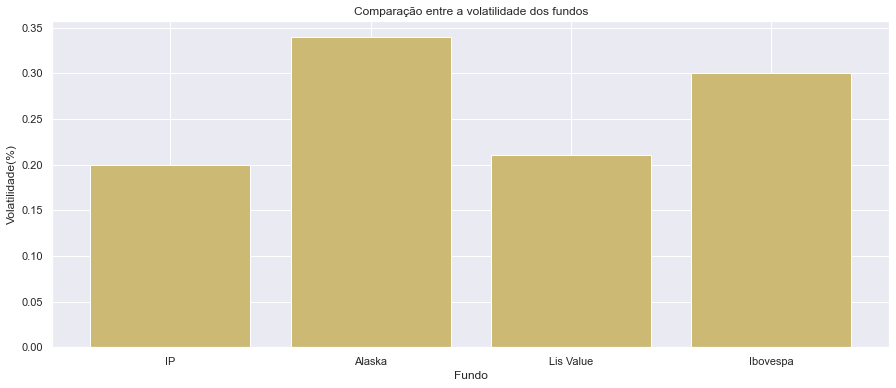

In [13]:
top = [('IP',vol_anual_ip),('Alaska',vol_anual_alaska),('Lis Value',vol_anual_lis),('Ibovespa',vol_anual_ibov)]
labels, values = zip(*top)

plt.bar(labels, values, color='y')
plt.xlabel('Fundo')
plt.ylabel('Volatilidade(%)') 
plt.title('Comparação entre a volatilidade dos fundos')
plt.show()

In [14]:
ip_retorno_perc, lis_retorno_perc, alaska_retorno_perc = retorno_percentual(ip_acm,lis_acm,alaska_acm)
risk_free = cdi_acm[-1]-1 

sharpe_ip = sharpe(ip_retorno_perc,risk_free,vol_anual_ip)
sharpe_lis = sharpe(lis_retorno_perc,risk_free,vol_anual_lis)
sharpe_alaska = sharpe(alaska_retorno_perc,risk_free,vol_anual_alaska)

print('Indice de Sharpe de 01/2019-12/2021 do Fundo IP Participações: ' +str(round(sharpe_ip,2)))
print('Indice de Sharpe de 01/2019-12/2021 do Fundo Lis Value: ' +str(round(sharpe_lis,2)))
print('Indice de Sharpe de 01/2019-12/2021 do Fundo Alaska: ' +str(round(sharpe_alaska,2)))

Indice de Sharpe de 01/2019-12/2021 do Fundo IP Participações: 3.53
Indice de Sharpe de 01/2019-12/2021 do Fundo Lis Value: 3.68
Indice de Sharpe de 01/2019-12/2021 do Fundo Alaska: 0.4


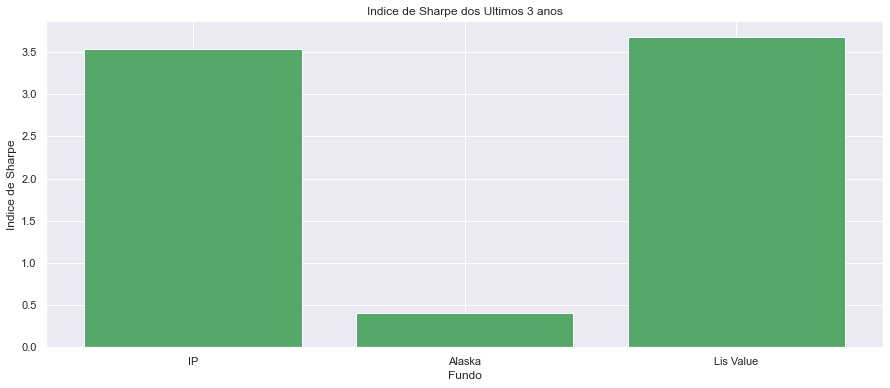

In [15]:
top = [('IP',sharpe_ip),('Alaska',sharpe_alaska),('Lis Value',sharpe_lis)]
labels, values = zip(*top)

plt.bar(labels, values,color='g')
plt.xlabel('Fundo')
plt.ylabel('Indice de Sharpe') 
plt.title('Indice de Sharpe dos Ultimos 3 anos')
plt.show()

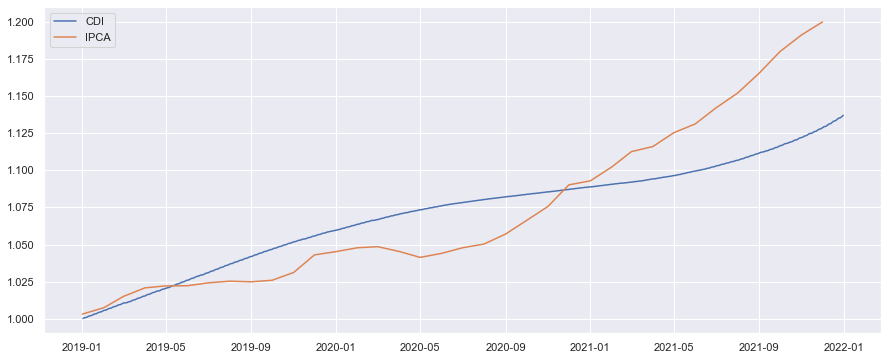

In [16]:
plt.plot(cdi_acm,label='CDI')
plt.plot(ipca_acm,label='IPCA')

plt.legend()
plt.show()

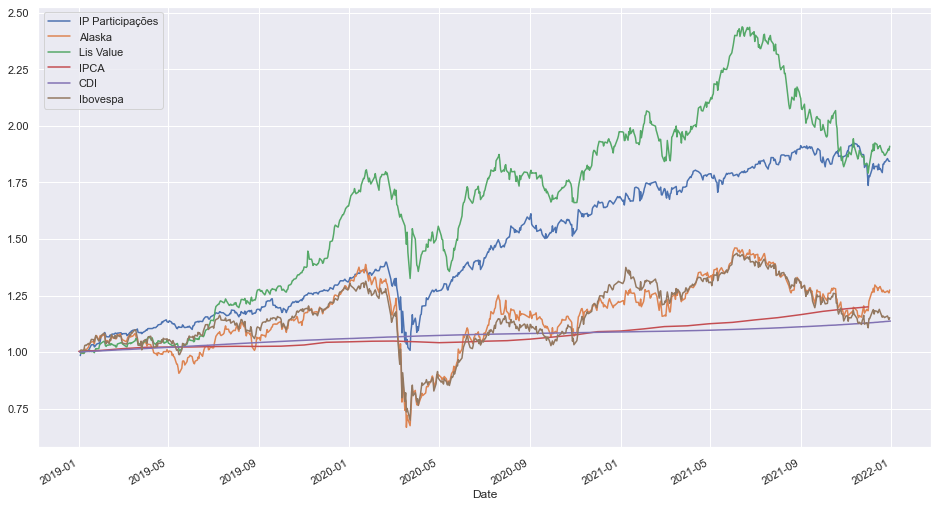

In [17]:
plt.subplots(figsize=(16,9))
ip_acm.plot(label='IP Participações')
alaska_acm.plot(label='Alaska')
lis_acm.plot(label='Lis Value')
ipca_acm.plot(label='IPCA')
cdi_acm.plot(label='CDI')
ibov_acm.plot(label='Ibovespa')

plt.legend(loc='upper left')
plt.show()